In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ext = 'drive/MyDrive/CV_Images/'#concentric.mat'

In [ ]:
! pip install imagehash

     |████████████████████████████████| 812 kB 14.2 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=cb3b6dc6eb3f76ad5f77bdc5ff3c940c9ef56a0b9b3175b027303dd0e5f22381
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built imagehash


In [ ]:
import cv2
import numpy as np
import json
import os
import random
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import seaborn as sns
import shutil
from PIL import Image
from matplotlib import image
from sklearn.cluster import AgglomerativeClustering
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Creating Data loader

In [ ]:
#path = '/content/drive/MyDrive/CV_Images'
path = '/content/drive/MyDrive/Computer vision/CV_Images'

In [ ]:
def data_loader(path, data_name, img_size): # data_name = 'cropped_train', # img_size = 128 
  all_images = []
  all_files = ['1040','1019', '1015', '1004', '1005','1039','1017','1021']#,'1018'] #,'1008' #,'1021'] # ['1015','1019'] # for now manually changed as issue in 1021, 1040 #'1004', '1005','1019',
  for label_folder in all_files:
    inside_path = path+'/'+ label_folder +'/'+ data_name
    fold = os.listdir(inside_path)
    for img  in fold:
      ext = os.path.splitext(img)[-1]
      if ext in ['.jpg', '.JPG']: # only jpg files no json files
        try:
          img_arr = cv2.imread(os.path.join(inside_path, img))
          #print(img_arr.shape)
          new_arr = cv2.resize(img_arr, (img_size, img_size)) 
          all_images.append([new_arr, label_folder])  
        except:
          pass 
    print(label_folder,data_name,len(all_images))
    random.shuffle(all_images)
  return all_images


# rename cropped_train to folder name which you want to run
img_train = data_loader(path, 'train', 224)
img_test_cr = data_loader(path, 'cropped_test', 224)
img_test_uncr = data_loader(path, 'uncropped_test', 224)

1040 train 37
1019 train 103
1015 train 208
1004 train 283
1005 train 345
1039 train 419
1017 train 497
1021 train 641
1040 cropped_test 12
1019 cropped_test 64
1015 cropped_test 81
1004 cropped_test 119
1005 cropped_test 162
1039 cropped_test 200
1017 cropped_test 221
1021 cropped_test 232
1040 uncropped_test 12
1019 uncropped_test 64
1015 uncropped_test 81
1004 uncropped_test 119
1005 uncropped_test 162
1039 uncropped_test 200
1017 uncropped_test 221
1021 uncropped_test 232


### Preprocesesing the data

In [ ]:
label_dict = {'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, 
              '1039':5, '1017':6, '1021':7}#, '1018':8}  #'1008':8, # add the label in the dictionary #'1004':0, '1005':1, 



classes  = 8#7 #6 #5 #2 # 4
def preprocesing(data, num_class):
  X, y = [], []
  for features, label in data:
    X.append(features)                 
    y.append(label)  
  X = np.array(X).reshape(-1, 224, 224, 3)
  encoding =np.vectorize(label_dict.get)(y) # label encoding
  y = np.array(encoding)
  y = tf.keras.utils.to_categorical(y, num_classes=num_class) # one hot encoding
  print("The shape of the dataset:", X.shape)
  print("The shape of the label dataset:", y.shape)
  #X = X/255
  return X, y

X_train, y_train = preprocesing(img_train,classes)
X_test_cr, y_test_cr = preprocesing(img_test_cr,classes)
X_test_uncr, y_test_uncr = preprocesing(img_test_uncr,classes)

The shape of the dataset: (641, 224, 224, 3)
The shape of the label dataset: (641, 8)
The shape of the dataset: (232, 224, 224, 3)
The shape of the label dataset: (232, 8)
The shape of the dataset: (232, 224, 224, 3)
The shape of the label dataset: (232, 8)


## VGG-16

In [ ]:
from keras.applications.vgg16 import preprocess_input
X_train = preprocess_input(X_train)
X_test_cr = preprocess_input(X_test_cr)
X_test_uncr = preprocess_input(X_test_uncr)


### Data Augmentation

In [ ]:
X_train_dg = ImageDataGenerator()
X_train_dg.fit(X_train)

#### Install this addon to run discriminative learning rate

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


### Model Architechture

In [ ]:
He_initializer = tf.keras.initializers.HeNormal()
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=X_train[0].shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc',kernel_initializer= He_initializer)(output)
  output = Dense(units=8, activation='softmax',kernel_initializer= He_initializer)(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  
  # Check the index of the trainable layer in Resnet and assign it below with learning_rate=1e-6
  
  optimizers = [
     tf.keras.optimizers.Adam(learning_rate=1e-6),
     tf.keras.optimizers.Adam(learning_rate=1e-3)]

  optimizers_and_layers = [(optimizers[1], vgg_model.layers[-1]),(optimizers[1], vgg_model.layers[-2]),
                            (optimizers[0], vgg_model.layers[-4]), (optimizers[0], vgg_model.layers[-5]),
                            (optimizers[0], vgg_model.layers[-8])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

  #model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


  # Compile VGG-16 model
  vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model




In [ ]:
vgg16_model = getVGG16Model()

553476096/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 

vgg16_model.fit(X_train_dg.flow(X_train, y_train), batch_size=50, epochs=40, validation_data=(X_test_uncr, y_test_uncr), callbacks=[es])
#vgg16_model.fit(X_train, y_train, epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50)#, callbacks=[es]) #validation_split=0.15,

Epoch 1/40
21/21 [==============================] - 22s 472ms/step - loss: 1.4028 - accuracy: 0.7769 - val_loss: 2.9219 - val_accuracy: 0.6379
Epoch 2/40
21/21 [==============================] - 4s 211ms/step - loss: 0.1712 - accuracy: 0.9735 - val_loss: 1.6712 - val_accuracy: 0.7716
Epoch 3/40
21/21 [==============================] - 4s 215ms/step - loss: 0.0714 - accuracy: 0.9844 - val_loss: 1.4721 - val_accuracy: 0.8190
Epoch 4/40
21/21 [==============================] - 4s 206ms/step - loss: 0.0047 - accuracy: 0.9969 - val_loss: 1.5241 - val_accuracy: 0.8147
Epoch 5/40
21/21 [==============================] - 4s 200ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 3.2734 - val_accuracy: 0.7845
Epoch 6/40
21/21 [==============================] - 4s 201ms/step - loss: 0.0087 - accuracy: 0.9938 - val_loss: 2.6213 - val_accuracy: 0.8190
Epoch 7/40
21/21 [==============================] - 4s 202ms/step - loss: 0.0122 - accuracy: 0.9953 - val_loss: 2.5630 - val_accuracy: 0.7974
Epoch

### Testing the accuracy of the model

In [ ]:
y_pred_cr = vgg16_model.predict(X_test_cr)
y_pred_uncr = vgg16_model.predict(X_test_uncr)

_, acc = vgg16_model.evaluate(X_test_cr, y_test_cr, verbose=0)
print('> %.3f' % (acc * 100.0))

_, acc = vgg16_model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
print('> %.3f' % (acc * 100.0))

In [ ]:
y_pred_cr_val = np.argmax(y_pred_cr, axis=1)
y_test_cr_val = np.argmax(y_test_cr,axis = 1)
print("Cropped")
print(y_pred_cr_val)
print(y_test_cr_val)


y_pred_uncr_val = np.argmax(y_pred_uncr, axis=1)
y_test_uncr_val = np.argmax(y_test_uncr,axis = 1)
print("Uncropped")
print(y_pred_uncr_val)
print(y_test_uncr_val)

Cropped
[7 5 1 4 0 4 5 1 3 6 3 4 7 4 4 3 0 3 2 5 4 3 5 5 4 4 1 2 7 5 4 7 3 4 1 5 2
 5 5 1 2 1 7 4 6 3 2 2 0 1 5 1 2 4 3 5 5 3 4 6 7 1 5 7 5 1 0 6 0 5 6 4 7 3
 6 1 6 1 5 4 4 4 4 1 7 2 5 2 2 3 0 1 7 1 1 3 1 5 1 3 5 4 7 3 3 4 1 5 4 2 4
 0 3 1 7 5 3 1 5 1 5 4 1 3 0 3 1 5 3 3 7 3 1 4 4 3 3 1 4 4 5 4 3 1 3 5 5 4
 4 0 3 2 3 5 3 5 1 5 1 1 1 4 5 6 4 4 5 1 7 2 3 1 3 3 3 3 1 4 2 7 4 3 1 0 0
 7 3 0 2 3 4 4 2 2 3 1 1 2 5 4 1 2 5 1 1 2 1 4 1 1 2 5 6 2 3 3 1 4 7 1 5 1
 5 1 3 3 0 1 4 4 3 3]
[7 5 1 4 1 4 5 1 3 6 3 4 7 4 4 3 0 6 6 5 4 3 5 5 4 4 1 6 1 5 4 7 6 4 1 5 2
 5 5 1 2 1 7 4 6 3 2 6 0 1 5 1 2 4 3 5 5 3 4 6 1 1 5 5 5 1 0 6 6 5 6 4 7 3
 6 1 6 1 5 4 4 4 4 1 7 6 5 2 2 3 0 1 7 1 1 3 1 5 1 6 5 4 1 3 3 4 1 5 4 6 4
 0 3 1 7 5 3 1 5 1 5 4 1 3 0 3 1 5 3 3 7 3 1 4 4 6 3 1 4 4 5 4 3 1 3 5 5 4
 4 0 3 2 3 5 3 5 1 5 1 1 1 6 5 6 4 4 5 1 7 6 3 1 3 3 3 4 1 4 2 7 4 3 1 0 0
 1 3 0 0 3 4 4 2 2 4 1 1 2 5 4 1 2 5 1 1 2 1 4 1 1 2 5 6 2 3 3 1 4 2 1 5 1
 5 2 3 3 0 1 4 4 3 3]
Uncropped
[4 1 4 1 2 4 4 1 1 4 4 7 1 1 1 3 0 7 3

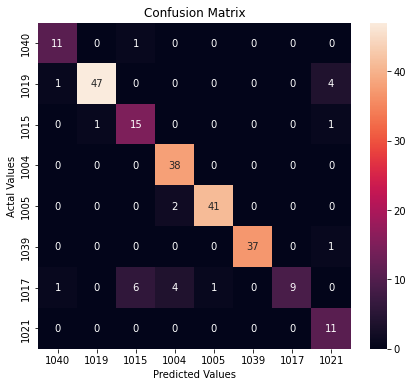

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm = confusion_matrix(y_test_cr_val, y_pred_cr_val)
cm_df = pd.DataFrame(cm,
                     index = ['1040', '1019', '1015', '1004', '1005', '1039','1017', '1021'], #,'1008', '1018'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                     columns = ['1040', '1019', '1015', '1004', '1005','1039','1017','1021']) #,'1008', '1018'])
                     #index = ['Low','Medium','High'], 
                     #columns = ['Low','Medium','High'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

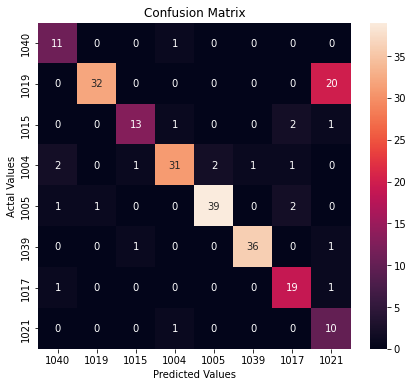

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm = confusion_matrix(y_test_uncr_val, y_pred_uncr_val)
cm_df = pd.DataFrame(cm,
                     index = ['1040', '1019', '1015', '1004', '1005', '1039','1017','1021'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                     columns = ['1040', '1019', '1015', '1004', '1005', '1039','1017','1021'])#,'1021'])
                     #index = ['Low','Medium','High'], 
                     #columns = ['Low','Medium','High'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Last four Convolution layers in VGG16

In [ ]:
X_train, y_train = preprocesing(img_train,classes)
X_test_cr, y_test_cr = preprocesing(img_test_cr,classes)
X_test_uncr, y_test_uncr = preprocesing(img_test_uncr,classes)

The shape of the dataset: (641, 224, 224, 3)
The shape of the label dataset: (641, 8)
The shape of the dataset: (232, 224, 224, 3)
The shape of the label dataset: (232, 8)
The shape of the dataset: (232, 224, 224, 3)
The shape of the label dataset: (232, 8)


In [ ]:
def get_activations_at(model,input_image, i):
  #index the layer 
  out_layer = model.layers[i]
  
  #change the output of the model 
  model = tf.keras.models.Model(inputs = model.inputs, outputs = out_layer.output)
  
  #return the activations
  return model.predict(input_image)

def postprocess_activations(activations):

  #using the approach in https://arxiv.org/abs/1612.03928
  output = np.abs(activations)
  output = np.sum(output, axis = -1).squeeze()

  #resize and convert to image 
  output = cv2.resize(output, (224, 224))
  # output = output.reshape((256,256,3))
  output /= output.max()
  output *= 255
  return 255 - output.astype('uint8')

def apply_heatmap(weights, img):
  #generate heat maps 
  heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
  heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
  return heatmap

def plot_heatmaps(model,test_image,rng):
  level_maps = None

  # rng = range(7,14)

  #given a range of indices generate the heat maps 
  for i in rng:
    activations = get_activations_at(model,array, i)
    weights = postprocess_activations(activations)
    heatmap_img = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
    fin = cv2.addWeighted(heatmap_img, 0.6, test_image, 0.4, 0)
    
    if level_maps is None:
      level_maps = fin
    else:
      level_maps = np.concatenate([level_maps, fin], axis = 1)
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  ax = plt.imshow(level_maps)
  plt.show()



In [ ]:
array.shape

(1, 224, 224, 3)

Test Image 1
Predicted Class Label 3


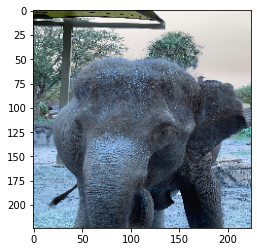

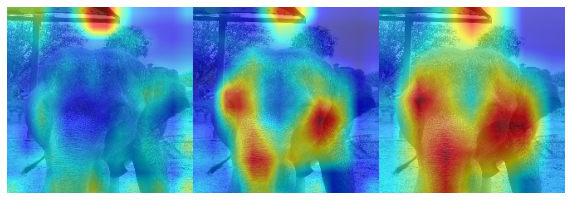


Test Image 2
Predicted Class Label 1


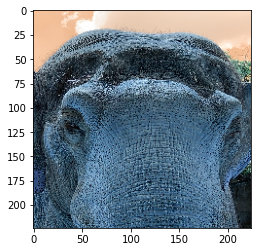

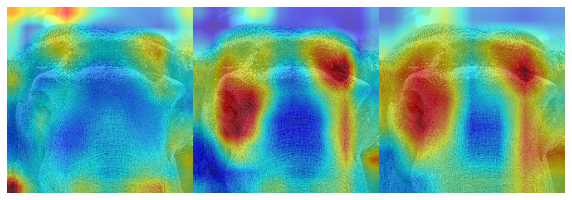


Test Image 3
Predicted Class Label 3


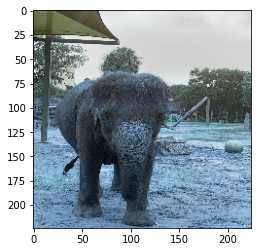

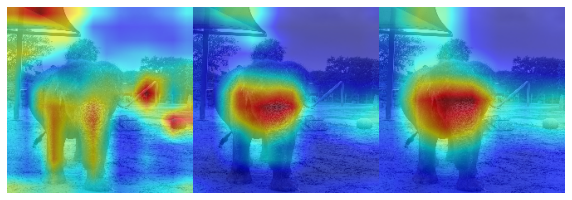


Test Image 4
Predicted Class Label 1


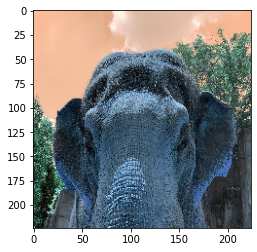

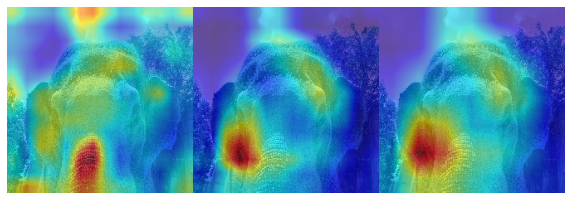


Test Image 5
Predicted Class Label 3


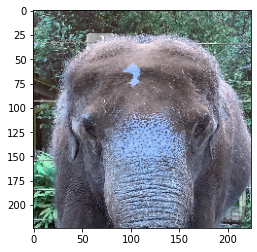

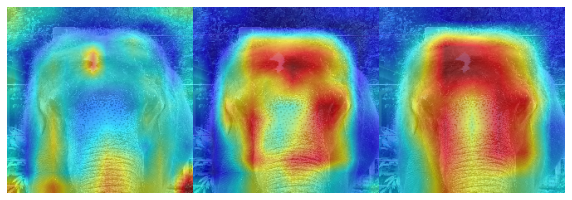


Test Image 6
Predicted Class Label 4


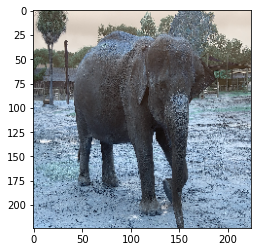

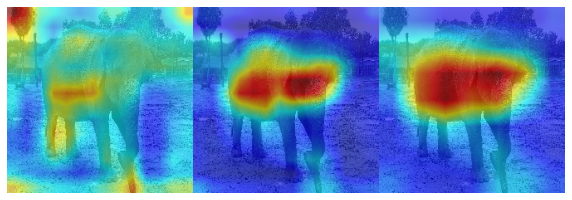


Test Image 7
Predicted Class Label 4


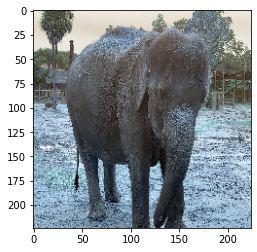

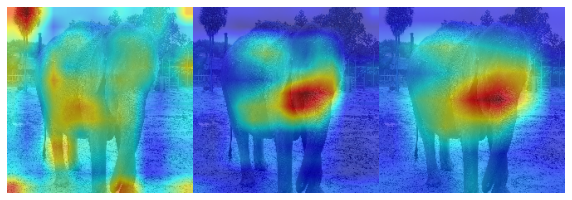


Test Image 8
Predicted Class Label 1


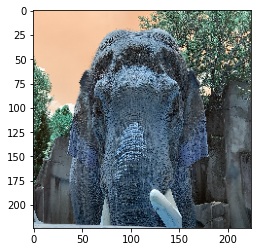

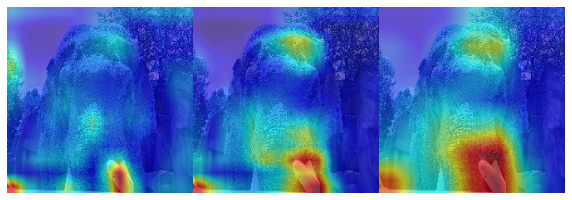


Test Image 9
Predicted Class Label 1


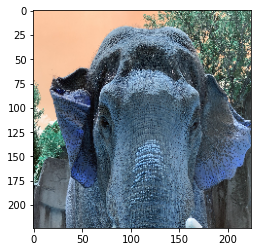

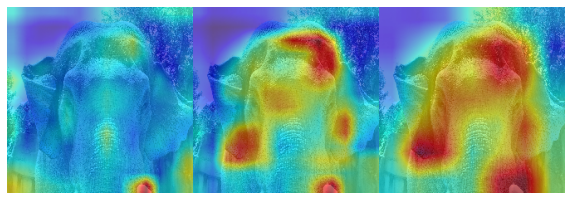


Test Image 10
Predicted Class Label 4


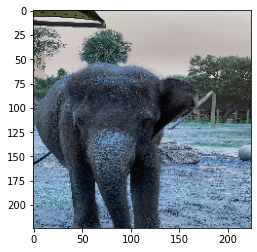

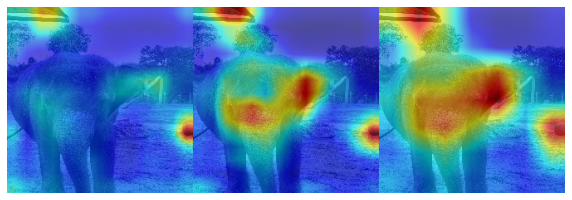

In [ ]:
for i in range(10):
  # before preprocess input 
  test_image = X_test_uncr[0+i,:,:,:]
  #array = keras.preprocessing.image.img_to_array(test_image)
  
  array = np.expand_dims(test_image, axis=0)
  # plt.figure(figsize=(10, 10))
  print("Test Image",i+1)
  plt.imshow(test_image)
  print("Predicted Class Label",np.argmax(vgg16_model.predict(array)))
  plot_heatmaps(vgg16_model,test_image,range(16, 19))
  print()

### Grad cam and Guided Grad cam

In [ ]:
x = X_test_uncr[40]
preprocessed_input = np.expand_dims(x, axis=0)
img = X_test_uncr[40]

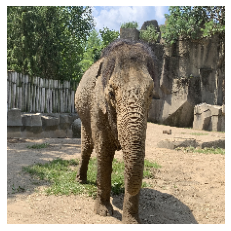

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
layer_name = 'block5_conv3'
'''create a model till  last convolutional layers to have the best compromise between high-level semantics and detailed spatial
information'''
gb_model = tf.keras.models.Model(
    inputs = [vgg16_model.inputs],    
    outputs = [vgg16_model.get_layer(layer_name).output]
)
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
layer_dict

In [ ]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

In [ ]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

In [ ]:
with tf.GradientTape() as tape:
 inputs = tf.cast(preprocessed_input, tf.float32)
 tape.watch(inputs)
 outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]

In [ ]:
weights = tf.reduce_mean(grads, axis=(0, 1))
grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    grad_cam += w * outputs[:, :, i]

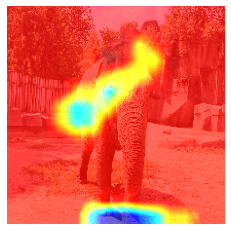

In [ ]:
grad_cam_img = cv2.resize(grad_cam.numpy(), (224, 224))
grad_cam_img = np.maximum(grad_cam_img, 0)
heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)

plt.imshow(output_image)
plt.axis("off");
plt.show()

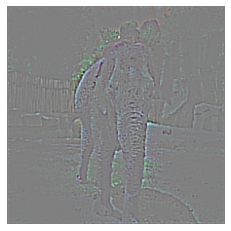

In [ ]:
#Visualizing the guided back prop
guided_back_prop =grads
gb_viz = np.dstack((
            guided_back_prop[:, :, 0],
            guided_back_prop[:, :, 1],
            guided_back_prop[:, :, 2],
        ))       
gb_viz -= np.min(gb_viz)
gb_viz /= gb_viz.max()
    
imgplot = plt.imshow(gb_viz)
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


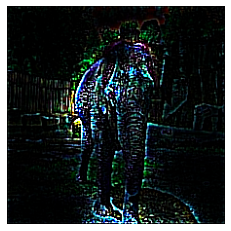

In [ ]:
from skimage.transform import resize
guided_cam = np.maximum(grad_cam, 0)
guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
guided_cam = resize(guided_cam, (224,224), preserve_range=True)
#pointwise multiplcation of guided backprop and grad CAM 
gd_gb = np.dstack((
        guided_back_prop[:, :, 0] * guided_cam,
        guided_back_prop[:, :, 1] * guided_cam,
        guided_back_prop[:, :, 2] * guided_cam,
    ))
imgplot = plt.imshow(gd_gb)
plt.axis("off")
plt.show()


#### VGG 19 new code


In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras.applications.vgg19 import preprocess_input

X_train = preprocess_input(X_train)
X_test_cr = preprocess_input(X_test_cr)
X_test_uncr = preprocess_input(X_test_uncr)


In [ ]:
X_train_dg = ImageDataGenerator()
X_train_dg.fit(X_train)

In [ ]:
He_initializer = tf.keras.initializers.HeNormal()
def getVGG19Model(lastFourTrainable=False):
  #vgg_model = VGG16(weights='imagenet', input_shape=X_train[0].shape, include_top=True)
  vgg_model = VGG19(weights='imagenet', input_shape=X_train[0].shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc',kernel_initializer= He_initializer)(output)
  output = Dense(units=8, activation='softmax',kernel_initializer= He_initializer)(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv4').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True
  
  optimizers = [
     tf.keras.optimizers.Adam(learning_rate=1e-6),
     tf.keras.optimizers.Adam(learning_rate=1e-3)]

  optimizers_and_layers = [(optimizers[1], vgg_model.layers[-1]),(optimizers[1], vgg_model.layers[-2]),
                            (optimizers[0], vgg_model.layers[-4]), (optimizers[0], vgg_model.layers[-5]),
                            (optimizers[0], vgg_model.layers[-8])]
  optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

  


  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model

In [ ]:
vgg19_model = getVGG19Model()
#vgg19_model = getVGG19Model()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 

vgg19_model.fit(X_train_dg.flow(X_train, y_train), batch_size=50, epochs=40, validation_data=(X_test_uncr, y_test_uncr), callbacks=[es])
#vgg16_model.fit(X_train, y_train, epochs=40, validation_data=(X_test_uncr, y_test_uncr), batch_size=50)#, callbacks=[es]) #validation_split=0.15,

Epoch 1/40
21/21 [==============================] - 7s 293ms/step - loss: 8.7018 - accuracy: 0.5757 - val_loss: 2.0818 - val_accuracy: 0.7112
Epoch 2/40
21/21 [==============================] - 5s 249ms/step - loss: 0.4100 - accuracy: 0.9142 - val_loss: 1.9067 - val_accuracy: 0.6897
Epoch 3/40
21/21 [==============================] - 6s 266ms/step - loss: 0.0385 - accuracy: 0.9844 - val_loss: 1.5023 - val_accuracy: 0.7802
Epoch 4/40
21/21 [==============================] - 6s 266ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 1.4282 - val_accuracy: 0.7845
Epoch 5/40
21/21 [==============================] - 6s 270ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.3988 - val_accuracy: 0.7974
Epoch 6/40
21/21 [==============================] - 5s 256ms/step - loss: 3.5910e-04 - accuracy: 1.0000 - val_loss: 1.3790 - val_accuracy: 0.7974
Epoch 7/40
21/21 [==============================] - 5s 258ms/step - loss: 2.3583e-04 - accuracy: 1.0000 - val_loss: 1.3712 - val_accuracy: 0.797

In [ ]:
y_pred_cr = vgg19_model.predict(X_test_cr)
y_pred_uncr = vgg19_model.predict(X_test_uncr)

In [ ]:
_, acc = vgg19_model.evaluate(X_test_cr, y_test_cr, verbose=0)
print('> %.3f' % (acc * 100.0))

_, acc = vgg19_model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
print('> %.3f' % (acc * 100.0))

> 85.776
> 79.741


In [ ]:
y_pred_cr_val = np.argmax(y_pred_cr, axis=1)
y_test_cr_val = np.argmax(y_test_cr,axis = 1)
print("Cropped")
print(y_pred_cr_val)
print(y_test_cr_val)


y_pred_uncr_val = np.argmax(y_pred_uncr, axis=1)
y_test_uncr_val = np.argmax(y_test_uncr,axis = 1)
print("Uncropped")
print(y_pred_uncr_val)
print(y_test_uncr_val)

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm = confusion_matrix(y_test_cr_val, y_pred_cr_val)
cm_df = pd.DataFrame(cm,
                     index = ['1040', '1019', '1015', '1004', '1005', '1039','1017'],#, '1021'], #'1040':0, '1019':1, '1015':2, '1004':3, '1005':4, '1021'
                     columns = ['1040', '1019', '1015', '1004', '1005','1039','1017'])#,'1021'])
                     #index = ['Low','Medium','High'], 
                     #columns = ['Low','Medium','High'])

#Plotting the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

#### EFFICIENT NET


In [ ]:
#from keras.applications.EfficientNetB0 import VGG19, preprocess_input
from keras.layers import Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam


In [ ]:
from keras.applications.efficientnet import EfficientNetB0, preprocess_input
X_train = preprocess_input(X_train)
X_test_cr = preprocess_input(X_test_cr)
X_test_uncr = preprocess_input(X_test_uncr)


In [ ]:
X_train_dg = ImageDataGenerator()
X_train_dg.fit(X_train)

In [ ]:
He_initializer = tf.keras.initializers.HeNormal()
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model, Input

def getEfficientNetModel(lastFourTrainable=False):
  #vgg_model = VGG16(weights='imagenet', input_shape=X_train[0].shape, include_top=True)
  #vgg_model = VGG19(weights='imagenet', input_shape=X_train[0].shape, include_top=True)
  
  width_shape = 224
  height_shape = 224
  image_input = Input(shape=(width_shape, height_shape, 3))
  eff_model = EfficientNetB0(include_top=False, input_tensor=image_input, weights="imagenet")

  # Make all layers untrainable
  for layer in eff_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = eff_model.get_layer('top_activation').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc',kernel_initializer= He_initializer)(output)
  output = Dense(units=8, activation='softmax',kernel_initializer= He_initializer)(output)
  eff_model = Model(eff_model.input, output)

  #Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    eff_model.get_layer('top_conv').trainable = True
    #eff_model.get_layer('block7a_project_conv').trainable = True
    
    #vgg_model.get_layer('fc1').trainable = True
    #vgg_model.get_layer('fc2').trainable = True
    eff_model.get_layer('new_fc').trainable = True
    
  # to run discriminative learning uncomment below
  # optimizers = [
  #    tf.keras.optimizers.Adam(learning_rate=1e-6),
  #    tf.keras.optimizers.Adam(learning_rate=1e-3)]

  # optimizers_and_layers = [(optimizers[1], eff_model.layers[-1]),(optimizers[1], eff_model.layers[-2]),
  #                           (optimizers[0], eff_model.layers[-6])]#, (optimizers[0], eff_model.layers[-8])]

  # optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

  # eff_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])


  # Compile VGG-16 model
  #eff_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  eff_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  eff_model.summary()
  return eff_model

In [ ]:
eff_model =  getEfficientNetModel()
#vgg19_model = getVGG19Model()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_13 (Rescaling)       (None, 224, 224, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_13 (Normalizatio  (None, 224, 224, 3)  7          ['rescaling_13[0][0]']           
 n)                                                                                               
                                                                                           

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True) 

#eff_model.fit(X_train_dg.flow(X_train, y_train), batch_size=50, epochs=25, validation_data=(X_test_uncr, y_test_uncr), callbacks=[es])
eff_model.fit(X_train, y_train, epochs=25, validation_data=(X_test_uncr, y_test_uncr), batch_size=50, callbacks=[es])#, callbacks=[es]) #validation_split=0.15,

Epoch 1/25
13/13 [==============================] - 2s 194ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 13.1741 - val_accuracy: 0.6207
Epoch 2/25
13/13 [==============================] - 2s 136ms/step - loss: 0.0027 - accuracy: 0.9984 - val_loss: 15.8946 - val_accuracy: 0.5388
Epoch 3/25
13/13 [==============================] - 2s 136ms/step - loss: 1.6255e-06 - accuracy: 1.0000 - val_loss: 19.7145 - val_accuracy: 0.4397
Epoch 4/25
13/13 [==============================] - 2s 137ms/step - loss: 0.0337 - accuracy: 0.9984 - val_loss: 13.0589 - val_accuracy: 0.4569
Epoch 5/25
13/13 [==============================] - 2s 136ms/step - loss: 6.3974e-08 - accuracy: 1.0000 - val_loss: 13.2274 - val_accuracy: 0.4871
Epoch 6/25
13/13 [==============================] - 2s 149ms/step - loss: 5.3563e-05 - accuracy: 1.0000 - val_loss: 13.3827 - val_accuracy: 0.4871


In [ ]:
y_pred_cr = eff_model.predict(X_test_cr)
y_pred_uncr = eff_model.predict(X_test_uncr)

In [ ]:
_, acc = eff_model.evaluate(X_test_cr, y_test_cr, verbose=0)
print('> %.3f' % (acc * 100.0))

_, acc = eff_model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
print('> %.3f' % (acc * 100.0))

> 66.810
> 62.069


In [ ]:
_, acc = eff_model.evaluate(X_test_cr, y_test_cr, verbose=0)
print('> %.3f' % (acc * 100.0))

_, acc = eff_model.evaluate(X_test_uncr, y_test_uncr, verbose=0)
print('> %.3f' % (acc * 100.0))

> 74.569
> 65.948
